In [1]:
import os
import numpy as np
import scipy.optimize as so
import matplotlib.pyplot as plt
plt.clf()
plt.close('all')
plt.style.use('classic')
import csv
import pandas as pd
import ROOT as r
%jsroot on

Welcome to JupyROOT 6.26/02


In [2]:
# file

def read_file(user):
    if user=='nicola':
        dirname = '/Users/nicola/Desktop/Advanced Laboratory A/data/20220517/252Cf_CLYC_both_COINCIDENCE_CH4_1/FILTERED/'
    if user=='vittoria':
        dirname = '/mnt/c/Users/UTENTE/Downloads/252Cf_CLYC_both_COINCIDENCE_CH4_1/FILTERED/'
    if user == "javi":
        dirname = "/Volumes/javimarino/Padova/AdvancedLab/data/20220517/60Co_252Cf_CLYC_both_COINCIDENCE/UNFILTERED/"
    filename_ch0 = dirname + 'CH_0@DT5725_1701_Data_60Co_252Cf_CLYC_both_1.csv'
    filename_ch2 = dirname + 'CH_2@DT5725_1701_Data_60Co_252Cf_CLYC_both_1.csv'
    filename_ch4 = dirname + 'CH_4@DT5725_1701_Data_60Co_252Cf_CLYC_both_1.csv'
    return filename_ch0, filename_ch2, filename_ch4

filename_ch0, filename_ch2, filename_ch4 = read_file('javi')

In [3]:
# retain data
df0 = pd.read_csv(filename_ch0, skiprows=1, header=None, sep=';')
df0.columns = (['TIMETAG', 'ENERGY', 'FLAGS'] + [x for x in range(len(df0.columns)-3)])
df2 = pd.read_csv(filename_ch2, skiprows=1, header=None, sep=';')
df2.columns = (['TIMETAG', 'ENERGY', 'FLAGS'] + [x for x in range(len(df2.columns)-3)])
df4 = pd.read_csv(filename_ch4, skiprows=1, header=None, sep=';')
df4.columns = (['TIMETAG', 'ENERGY', 'FLAGS'] + [x for x in range(len(df4.columns)-3)])



,TIMETAG,ENERGY,FLAGS,0,1,2,3,4,5,6,...,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495
0,1515996000,114,0x0,3389,3389,3405,3405,3396,3396,3389,...,3404,3404,3405,3405,3404,3404,3396,3396,3405,3405
1,2111988000,204,0x0,3389,3389,3427,3427,3425,3425,3393,...,3416,3416,3408,3408,3401,3401,3409,3409,3402,3402
2,4026140000,89,0x0,3391,3391,3389,3389,3380,3380,3375,...,3451,3451,3448,3448,3461,3461,3441,3441,3413,3413
3,7162124000,95,0x0,3393,3393,3392,3392,3404,3404,3394,...,3405,3405,3396,3396,3396,3396,3400,3400,3402,3402
4,7522468000,270,0x0,3390,3390,3404,3404,3403,3403,3390,...,3426,3426,3406,3406,3408,3408,3422,3422,3410,3410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97852,164548898420000,183,0x0,3403,3403,3393,3393,3397,3397,3398,...,3415,3415,3412,3412,3409,3409,3418,3418,3412,3412
97853,164549044264000,229,0x0,3388,3388,3397,3397,3394,3394,3387,...,3411,3411,3424,3424,3416,3416,3403,3403,3426,3426
97854,164549185804000,234,0x0,3399,3399,3404,3404,3392,3392,3390,...,3402,3402,3414,3414,3401,3401,3404,3404,3427,3427
97855,164550366944000,90,0x0,3394,3394,3399,3399,3393,3393,3393,...,3398,3398,3414,3414,3407,3407,3389,3389,3392,3392


In [4]:
def resolution_fit(E, a, b):
    return a / np.sqrt(E) + b
    
def linear(x, a, b):
    return a + b * x
    
def inv_linear(y, a, b): # invert the linear for y = a + b * x
    return (y - a) / b

In [106]:
bins = 16300
xMin, xMax = 180, 260


h = r.TH1I("hist", "", xMax - xMin, xMin, xMax)

for entry in df0["ENERGY"]:         
     # Now you have acess to the leaves/branches of each entry in the tree, e.g.
     h.Fill(entry)
#h.Rebin(64)
h.GetXaxis().SetRangeUser(xMin, xMax)

Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


In [107]:
c1 = r.TCanvas("c1", "", 800, 600)
h.Draw()
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [108]:
if "60Co" in filename_ch0:
    xval = [1172, 1332]
if "133Ba" in filename_ch0:
    xval = [276.4, 302.85, 356.02, 383.8]
if "22Na" in filename_ch0:
    xval = [511, 1275]
if "137Cs" in filename_ch0:
    xval = [662]

npeaks = len(xval)
resolution = np.zeros(npeaks)
mean = np.zeros(npeaks)
sigma = np.zeros(npeaks)
umean = np.zeros(npeaks)
usigma = np.zeros(npeaks)

In [109]:
ss = r.TSpectrum(npeaks)
nfound = ss.Search(h, 5, "new", 0.1)
print("\n --------- Found ", nfound, " peaks ---------")
xpeaks = ss.GetPositionX()


 --------- Found  2  peaks ---------


Warning in <TSpectrum::SearchHighRes>: Peak buffer full


In [110]:
for i in range(npeaks):
    xp = xpeaks[i]
    print(" ************ Peak at: ", xp, "\n")
    fun1 = r.TF1("fun1name", "gaus", xp - 10, xp + 10)
    h.Fit(fun1,"RQN")
    fun2 = r.TF1("fun2name", "gaus", fun1.GetParameter(1) - 1.5 * fun1.GetParameter(2), fun1.GetParameter(1) + 1.5 * fun1.GetParameter(2))
    h.Fit(fun2, "R+")
    mean[i] = fun2.GetParameter(1)
    sigma[i] = fun2.GetParameter(2)
    umean[i] = fun2.GetParErrors()[1]
    usigma[i] = fun2.GetParErrors()[2]

    resolution[i]=((2.35 * sigma[i]) / mean[i]) * 100;
    print("\nRESULTS:  Mean at: ", mean[i], " with sigma ", sigma[i], ", FWHM of ", 2.35 * sigma[i], ", and resolution of ", resolution[i], " %\n")

 ************ Peak at:  204.5 


RESULTS:  Mean at:  204.25040642769576  with sigma  5.5805486641546995 , FWHM of  13.114289360763545 , and resolution of  6.4206919291521585  %

 ************ Peak at:  233.5 


RESULTS:  Mean at:  232.82721895201067  with sigma  5.058457695811827 , FWHM of  11.887375585157793 , and resolution of  5.1056640364750345  %

 FCN=65.7707 FROM MIGRAD    STATUS=CONVERGED      62 CALLS          63 TOTAL
                     EDM=7.24859e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.8 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.07587e+02   8.10021e+00  -1.93691e-02  -5.16530e-05
   2  Mean         2.04250e+02   1.00497e-01   1.47089e-03  -4.83428e-04
   3  Sigma        5.58055e+00   1.29595e-01  -2.19051e-05   1.30286e-02
 FCN=14.5285 FROM MIGRAD    STATUS=CONVERGED      78 CALLS          79 TOTAL
                     EDM=2.15287e-0

In [111]:
sol = so.curve_fit(resolution_fit, xval, resolution, sigma = 2.35 * usigma / mean, absolute_sigma = True, maxfev = 300)
coef, cov = sol
a, b = coef; ua, ub = np.sqrt(np.diag(cov))

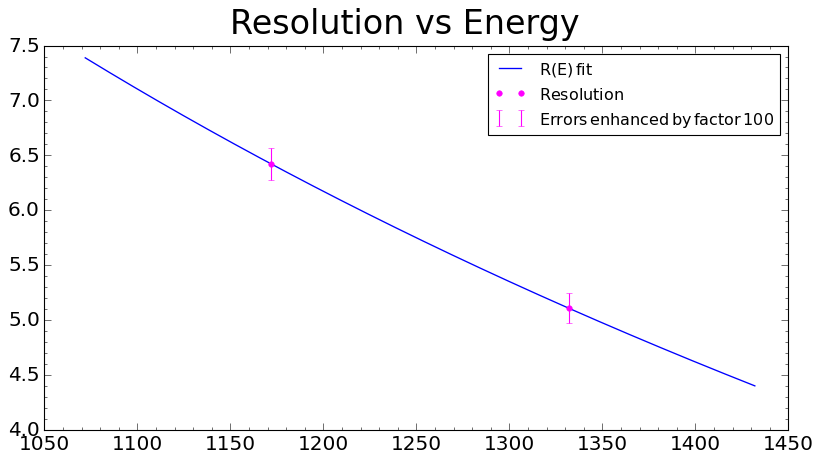

In [112]:
fig, ax = plt.subplots(); fig.patch.set_facecolor('xkcd:white')
plt.rcParams['figure.figsize'] = [12, 6]
plt.suptitle("Resolution vs Energy", fontsize = 30)
ax.tick_params(which = 'both', axis = 'both', direction='in', right = True, top = True, length = 6)
ax.minorticks_on()
ax.tick_params(which = 'minor', axis = 'both', direction='in', right = True, top = True, length = 3)
ax.tick_params(axis = 'both', labelsize = 18)

enh_errors = 100
xaux = np.linspace(xval[0] - 100, xval[-1] + 100, 1000)
ax.plot(xaux, resolution_fit(xaux, *coef), color = 'blue', linewidth = 1.2, linestyle = 'solid', label = '$R(E)\, {\\rm fit}$')
ax.plot(xval, resolution, marker = 'o', markersize = 5, markeredgecolor = "magenta", color = "magenta", lw = 0, label = "${\\rm Resolution}$")
ax.errorbar(xval, resolution, yerr = 100 * 2.35 * usigma / mean, capsize = 3., elinewidth = 1., lw = 0, color = "magenta", label = "${\\rm Errors\, enhanced\, by\, factor}\, %i$" % enh_errors)
ax.legend(loc = "best")

In [113]:
res_at_one25 = resolution_fit(1250., *coef)
print("\n ************** RESOLUTION @ 1.25 MeV:  ", res_at_one25, "% ************** \n")


 ************** RESOLUTION @ 1.25 MeV:   5.748069849051882 % ************** 



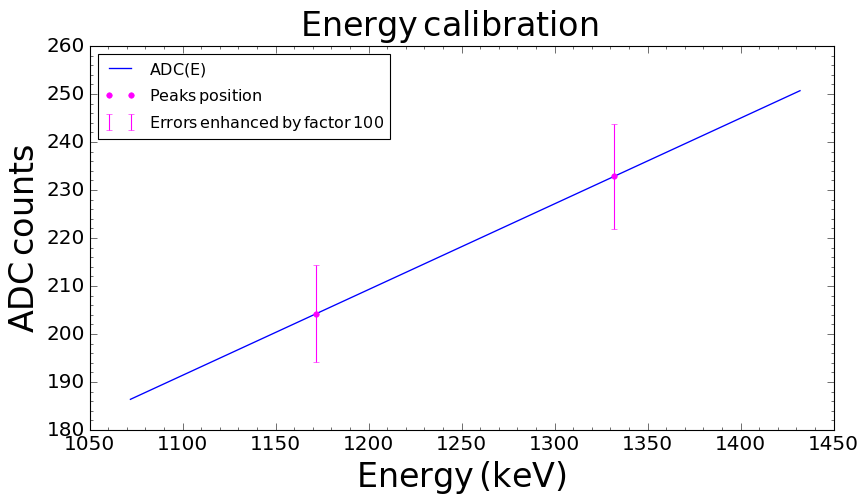

In [114]:
fig, ax = plt.subplots(); fig.patch.set_facecolor('xkcd:white')
plt.rcParams['figure.figsize'] = [12, 6]
plt.suptitle("${\\rm Energy\, calibration}$", fontsize = 30)
ax.tick_params(which = 'both', axis = 'both', direction='in', right = True, top = True, length = 6)
ax.minorticks_on()
ax.tick_params(which = 'minor', axis = 'both', direction='in', right = True, top = True, length = 3)
ax.tick_params(axis = 'both', labelsize = 18)
ax.set_xlabel("${\\rm Energy\, (\mathrm{keV})}$", fontsize = 30)
ax.set_ylabel("${\\rm ADC\, counts}$", fontsize = 30)

sol = so.curve_fit(linear, xval, mean, sigma = sigma, absolute_sigma = True)
coef, cov = sol
a, b = coef; ua, ub = np.sqrt(np.diag(cov))

enh_errors = 100
ax.plot(xaux, linear(xaux, *coef), color = 'blue', linewidth = 1.2, linestyle = 'solid', label = '${\\rm ADC(E)}$')
ax.plot(xval, mean, marker = 'o', markersize = 5, markeredgecolor = "magenta", color = "magenta", lw = 0, label = "${\\rm Peaks\, position}$")
ax.errorbar(xval, mean, yerr = enh_errors * umean, capsize = 3., elinewidth = 1., lw = 0, color = "magenta", label = "${\\rm Errors\, enhanced\, by\, factor}\, %i$" % enh_errors)
ax.legend(loc = "best")

In [115]:
print(a, b)

-5.074745312910917 0.17860507827696817


In [68]:
hcal = r.TH1I("hist_cal", "Calibrated spectrum", round(inv_linear(xMax - xMin, *coef) / 2), inv_linear(xMin, *coef), inv_linear(xMax, *coef))

for entry in df0["ENERGY"]:         
     hcal.Fill(inv_linear(entry, *coef))


hcal.GetXaxis().SetRangeUser(inv_linear(xMin, *coef), inv_linear(xMax, *coef))
hcal.GetXaxis().SetTitle("Photon energy [keV]");
hcal.GetYaxis().SetTitle("counts / %1.2f keV" % hcal.GetXaxis().GetBinWidth(0))

Warning in <TROOT::Append>: Replacing existing TH1: hist_cal (Potential memory leak).


In [69]:
c2 = r.TCanvas("c2", "", 800, 600)
hcal.Draw()
c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


In [45]:
try:
    os.makedirs(analysis_dir + date)
except FileExistsError:
    # directory already exists
    pass

with open(analysis_dir + date + fileName + "_cal.csv", 'w') as f:
    for i in range(npeaks):
        f.write(",%i peak" % xval[i])
    f.write("\n")
    f.write("Resolution (per cent)")
    for i in range(npeaks):
        f.write(",%.3f" % resolution[i])
f.close()

NameError: name 'analysis_dir' is not defined

In [ ]:
os.remove(output) # deleting the file once we have done the analysis